In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import solve_for_masses as em
import mass_loss as ms
from numpy.random import normal
%matplotlib inline

This is just a re-write of the Kepler-36 model for TOI-270c

To start with we need to make some basic choices. First we need to assume the composition of the solid cores. This uses the Fortney et al. (2007, ApJ 659 1661) mass-radius relation. They can either be iron-rock or water-rock (both the iron fraction and ice fraction cannot be non-zero). 

In [2]:
Xiron = 1./3.
Xice = 0.

As discussed in the paper (Owen & Campos Estrada, 2020), one needs to choose a Kelvin-Helmholtz timescale for the H/He atmospheres at which to do the comparision (i.e. at what age is mass-loss important), the answer is very weakly dependent on this value, here we pick the standard value of 100 Myr.

In [3]:
Tkh_Myr=100.

Now we input the planetary and stellar parameters and their errors from the Van Eylen paper.

In [4]:
K36s_M = 0.386 # stellar mass,  solar masses
K36s_Mer = 0.008 # stellar mass error, solar masses
K36s_Teff = 3506 # Stellar effective temperature, K
K36s_Teffer = 70 # stellar effective temperature error, K
K36s_R = 0.378 # stellar radius, solar radii - note we should really use the MS radii but this is and example.
K36s_Rer=0.011 # stellar radius error, solar radii 
K36s_age=5000 # stellar age, Myr
K36s_age_er=1000. #stellar age error, Myr

#radius in earth unit and period in days + errors for planet b
K36b_R = 1.206
K36b_Rer=0.039
K36b_P = 3.3601538
K36b_Per = 0.0000048 # make period errors symmetric

#radius in earth unit and period in days + errors for planet c
K36c_R = 2.133
K36c_Rer=0.058
K36c_P = 11.379573
K36c_Per = 0.000013

Now do the calculation for the minimum mass of TOI-270d to be consistent with photoevaporation assuming the mean values for all parameters.

In [5]:
# evaluate minimum mass for the mean value and print it

system = em.psystem('Kepler36')
system.add_planet('36b',K36b_R,K36b_Rer,K36b_P,K36b_Per)
system.add_planet('36c',K36c_R,K36c_Rer,K36c_P,K36c_Per)
system.star.mass=K36s_M
system.star.radius=K36s_R
system.star.Teff=K36s_Teff
system.star.age = K36s_age
system.update_planet_info()
system.above_or_below_valley()
system.mass_rocky(Xiron,Xice)

ms.find_hardest_rocky(system,Tkh_Myr,Xiron,Xice)

Mout, flag = ms.min_mass_gaseous(system.planets[0],system.planets[1],Tkh_Myr,Xiron,Xice,system.star.age)
Mmedian = np.copy(Mout)

print(Mmedian,'Mearth')

0.5329044209085879 Mearth


/home/jeowen/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


However, given the stellar and planetary parameters contain errors these must be included, therefore we assume the errors are gaussian and randonly sample them. Here we use 1000 samples, but a value should be chosen such that the upper-limit is converged.  

In [6]:
Mout_error= np.zeros(1000)
flag_out = np.zeros(1000,dtype=np.int8)

for i in range(np.size(Mout_error)):
    
    K36b_R_use = normal(K36b_R,K36b_Rer,1)
    K36b_P_use = normal(K36b_P,K36b_Per,1)
    
    K36c_R_use = normal(K36c_R,K36c_Rer,1)
    K36c_P_use = normal(K36c_P,K36c_Per,1)
    
    system = em.psystem('Kepler36_%d' %i)
    system.add_planet('36b',K36b_R_use,K36b_Rer,K36b_P_use,K36b_Per)
    system.add_planet('36c',K36c_R_use,K36c_Rer,K36c_P_use,K36c_Per)
    system.star.mass=normal(K36s_M,K36s_Mer,1)
    system.star.radius=normal(K36s_R,K36s_Rer,1)
    system.star.Teff=normal(K36s_Teff,K36s_Teffer,1)
    system.star.age = normal(K36s_age,K36s_age_er,1)
    system.update_planet_info()
    system.above_or_below_valley()
    system.mass_rocky(Xiron,Xice)
    
    ms.find_hardest_rocky(system,Tkh_Myr,Xiron,Xice)

    Mout, flag = ms.min_mass_gaseous(system.planets[0],system.planets[1],Tkh_Myr,Xiron,Xice,system.star.age)
    
    Mout_error[i] = Mout
    flag_out[i]=flag

Now plot the resulting distrubtion and calculate the 95% upper-limit, the 95% upperlimit is plotted as a dashed line, the actual measured mass is plotted as the dotted line. This indicates (as known from previous work - Lopez & Fortney 2013, Owen & Morton 2016) that Kepler-36 is consistent with the photoevaporation model. The value to quote, as we are concerned with the minimum mass to be consistent is something like the 95% upper-limit, not the mean or meadian value. 

The 95% upper limit to be consistent with photoevaporation is
0.44307523460445236 Mearth


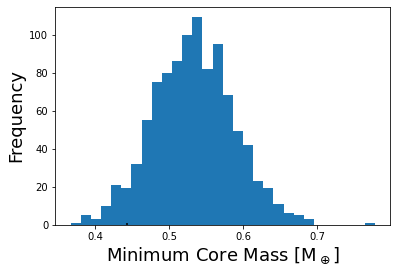

In [7]:
plt.hist(Mout_error,bins=30,lw=2)
plt.plot([(np.percentile(Mout_error,5.)),(np.percentile(Mout_error,5.))],[0.,1.],'--',color='k')
plt.ylabel('Frequency',fontsize=18)
plt.xlabel(r'Minimum Core Mass [M$_\oplus$]',fontsize=18)
print('The 95% upper limit to be consistent with photoevaporation is')
print((np.percentile(Mout_error,5.)),'Mearth')